<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "5D"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/5D/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


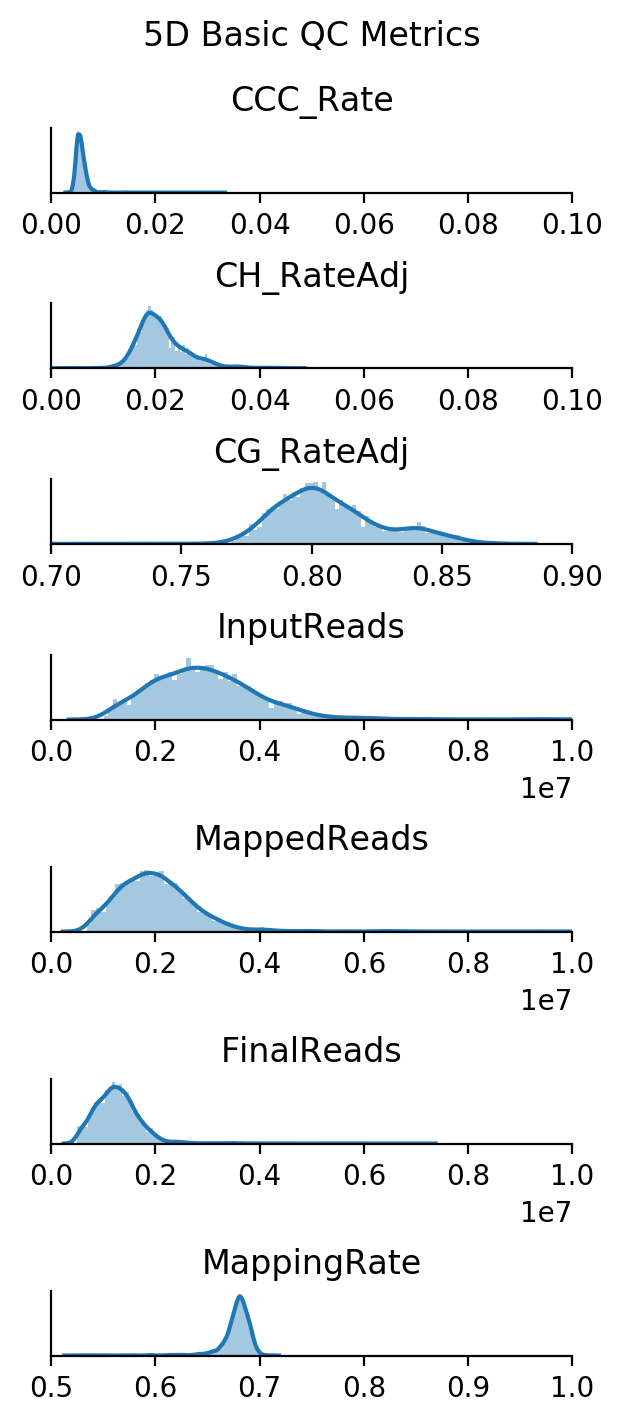

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

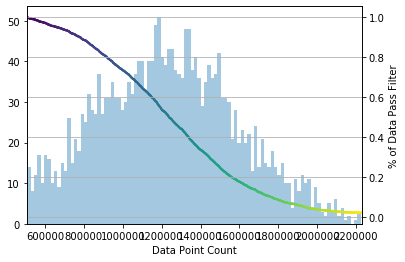

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2319/2319 (100.0%)
CG_RateAdj passed 2319/2319 (100.0%)
CH_RateAdj passed 2319/2319 (100.0%)
FinalReads passed 2319/2319 (100.0%)
MappingRate passed 2319/2319 (100.0%)
Overall passed 2319/2319 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180605 1101
180612 1218


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 297 77.3%
ad002 292 76.0%
ad004 304 79.2%
ad006 291 75.8%
ad007 284 74.0%
ad008 248 64.6%
ad010 296 77.1%
ad012 307 79.9%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
5D_M_0,/gale/raidix/rdx-4/CEMBA_RS1/5D/CEMBA180605_5D...,0.00606,0.81940,0.81830,0.02802,0.02209,920916.0,2077588,1350220.0,5D,...,14.524371,-10.997611,32.791114,16.383270,IT-L5 Grik3,8.162003,-0.112601,-18.866068,30.953625,True
5D_M_1,/gale/raidix/rdx-4/CEMBA_RS1/5D/CEMBA180605_5D...,0.00654,0.82486,0.82371,0.03194,0.02557,909549.0,2115338,1355414.0,5D,...,23.493471,5.903201,-24.477016,-11.715955,CT-L6 Hcrtr2,-8.188154,-20.639330,-32.302786,15.788404,True
5D_M_10,/gale/raidix/rdx-4/CEMBA_RS1/5D/CEMBA180605_5D...,0.00568,0.80457,0.80345,0.02657,0.02101,1502130.0,3623384,2498575.0,5D,...,15.534102,-7.058651,6.985366,-6.850243,IT-L6 Man1c1,-4.177743,-6.564291,-16.396947,-9.409119,True
5D_M_100,/gale/raidix/rdx-4/CEMBA_RS1/5D/CEMBA180605_5D...,0.00608,0.79991,0.79869,0.02778,0.02183,762853.0,1719694,1174127.0,5D,...,13.822527,-11.212006,30.132449,16.350346,IT-L5 Grik3,7.691524,-0.394965,-18.858582,29.484965,True
5D_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/5D/CEMBA180605_5D...,0.00478,0.81920,0.81833,0.02387,0.01918,1834096.0,4374340,3013398.0,5D,...,20.946033,7.350414,-42.740442,-31.549816,CT-L6 Il1rap,-8.300577,-17.075447,40.295867,4.816707,True
5D_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/5D/CEMBA180605_5D...,0.00454,0.78530,0.78432,0.02163,0.01717,1803865.0,4417138,3031638.0,5D,...,-0.968527,-10.807763,-18.694251,46.408888,IT-L23 Cux1,3.271868,5.471975,27.817182,-5.984961,True
5D_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/5D/CEMBA180605_5D...,0.00486,0.80346,0.80250,0.02386,0.01909,1387220.0,3285574,2248054.0,5D,...,4.921141,-14.740839,-28.276435,1.633410,IT-L4 Shc3,-4.621153,5.426789,8.019862,23.379174,True
5D_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/5D/CEMBA180605_5D...,0.00494,0.82098,0.82009,0.02281,0.01796,1611399.0,3898522,2678352.0,5D,...,21.427595,8.474378,-40.423698,-33.790983,CT-L6 Il1rap,-5.556746,-16.238619,25.918446,0.085445,True
5D_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/5D/CEMBA180605_5D...,0.00545,0.81282,0.81179,0.02719,0.02186,1332355.0,3272342,2238769.0,5D,...,-18.420044,-17.644724,-38.733208,-29.786134,CGE-Vip Clstn2,-1.504803,-13.309151,17.282453,14.994728,True
5D_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/5D/CEMBA180605_5D...,0.00623,0.82304,0.82193,0.03138,0.02531,1344142.0,3249872,2224653.0,5D,...,24.362186,6.033311,-21.318886,-13.524344,CT-L6 Tnr,-7.606201,-22.813726,-37.354519,4.724636,True
